In [1]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
architectures = ['test1-pol1', 'test2-pol1', 'test2-pol2']
policies = list(set([x for x in map(lambda y: y.split('-', 1)[1], architectures)]))
arch_pol_tupl_ls = [(x, y) for x, y in map(lambda x: x.split('-', 1), architectures)]
skip_layers_values = [1, 2, 3, 4, 8, 16, 32]
bench_types = ['quality', 'speed']
runs = 10

In [3]:
reports_list = os.listdir()

def printList(x):
    print()
    for entry in x:
        print(entry)
        
reports_list = list(filter(lambda x: 'speed' in x or 'quality' in x, sorted(reports_list)))
print('***************************************')
print(f'Found {len(reports_list)} files in reports.')
print('***************************************')

speed_reports = list(filter(lambda x: 'speed' in x and not 'msdnet' in x, reports_list))
quality_reports = list(filter(lambda x: 'quality' in x and not 'msdnet' in x, reports_list))
print()
print(f'{len(speed_reports)} Speed reports vailable: ')
printList(speed_reports)
print()
print(f'{len(quality_reports)} Quality reports available:')
printList(quality_reports)

***************************************
Found 54 files in reports.
***************************************

28 Speed reports vailable: 

speed-densenet121-none-run.csv
speed-densenet121-skip-last-n-block-run.csv
speed-densenet121-skip-last-run.csv
speed-densenet121-skip-norm-n-run.csv
speed-densenet121-skip-run.csv
speed-densenet169-none-run.csv
speed-densenet169-skip-last-n-block-run.csv
speed-densenet169-skip-last-run.csv
speed-densenet169-skip-norm-n-run.csv
speed-densenet169-skip-run.csv
speed-resnet101-drop-last-rand-n-run.csv
speed-resnet101-drop-rand-n-run.csv
speed-resnet101-none-run.csv
speed-resnet152-drop-last-rand-n-run.csv
speed-resnet152-drop-rand-n-run.csv
speed-resnet152-none-run.csv
speed-resnet18-drop-last-rand-n-run.csv
speed-resnet18-drop-norm-n-run.csv
speed-resnet18-drop-rand-n-run.csv
speed-resnet18-none-run.csv
speed-resnet34-drop-last-rand-n-run.csv
speed-resnet34-drop-norm-n-run.csv
speed-resnet34-drop-rand-n-run.csv
speed-resnet34-none-run.csv
speed-resnet50-

      run  skip_n bench_type         arch   pol      prec       rec       acc  \
0       0       0    quality  densenet121  none  0.682875  0.682879  0.703656   
841     0       0    quality  densenet169  none  0.600423  0.600720  0.612246   
2132    0       0    quality     resnet18  none  0.684989  0.684924  0.685383   
2673    0       0    quality     resnet34  none  0.701903  0.703409  0.705718   
3214    0       0    quality     resnet50  none  0.621564  0.621515  0.609135   

            f1  time  
0     0.682744   0.0  
841   0.592302   0.0  
2132  0.671122   0.0  
2673  0.688687   0.0  
3214  0.600557   0.0  
             arch   pol      prec       rec       acc        f1
0     densenet121  none  0.682875  0.682879  0.703656  0.682744
841   densenet169  none  0.600423  0.600720  0.612246  0.592302
2132     resnet18  none  0.684989  0.684924  0.685383  0.671122
2673     resnet34  none  0.701903  0.703409  0.705718  0.688687
3214     resnet50  none  0.621564  0.621515  0.609135  

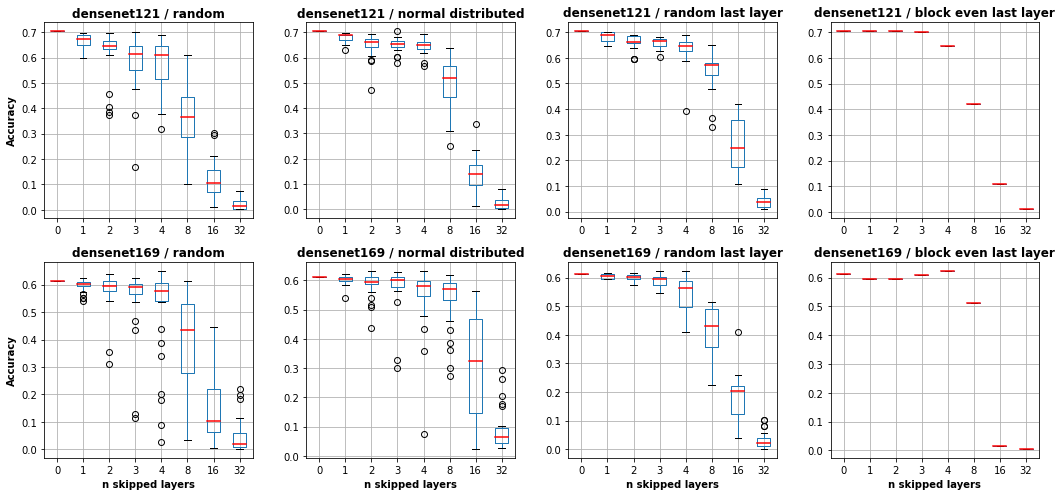

In [4]:
pol_trans = {
    'skip': 'random',
    'skip-last': 'random last layer',
    'skip-norm-n': 'normal distributed',
    'skip-last-n-block': 'block even last layer',
    'drop-rand-n': 'random',
    'drop-last-rand-n': 'last layer',
    'drop-norm-n': 'normal distributed'
}

def getDataFrameFromReports(csv_files):
    li = []
    for entry in csv_files:
        df = pd.read_csv(entry)
        if len(df) == 0:
            print("No data found in", entry)
        li.append(df)
    return pd.concat(li, axis=0, ignore_index=True)


s_df = getDataFrameFromReports(speed_reports)
q_df = getDataFrameFromReports(quality_reports)

base_q_df = q_df.query('pol == "none"')
print(base_q_df)

print(base_q_df[['arch', 'pol', 'prec', 'rec', 'acc', 'f1']])

print(s_df.columns)
print(q_df['arch'])

def printBoxPlotForArchAndPol(data_frame, arch_name, policy_name, ax, i=None, j=None, last_idx=None):
    df, an, pn = data_frame, arch_name, policy_name

    df = df.query(f'arch == "{an}"')
    df = df.query(f'pol == "{pn}"')
    df = df.append(data_frame.query(f'arch == "{an}"').query(f'pol == "none"'))
    if len(df) == 0:
        print("No content found")
        return
    #print(df)
    bp = df.boxplot(
        column=['acc'], 
        by='skip_n', 
        figsize=(8, 6), 
        ax=ax,
        medianprops=dict(linestyle='-', linewidth=1.5, color='r')
        )
    fig = np.asarray(bp).reshape(-1)[0].get_figure()
    fig.suptitle('')
    if j is not None and j == 0:
    #if policy_name == 'skip' or policy_name == 'drop-rand-n':
        ax.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
    else:
        ax.set_ylabel('')

    if last_idx is not None and i is not None and i == last_idx:
        ax.set_xlabel('n skipped layers', fontsize=10, fontweight='bold')
    else:
        ax.set_xlabel('')
    ax.set_title(f'{an} / {pol_trans[pn]}', fontsize=12, fontweight='bold')

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))

from optparse import OptionParser
import inspect

#member_list = inspect.getmembers(axes[0, 0])
#for mem in member_list:
#    print(mem)

d_archs = ['densenet121', 'densenet169']
dense_pols = ['skip', 'skip-norm-n', 'skip-last', 'skip-last-n-block']

for i, arch in enumerate(d_archs):
    for j, pol in enumerate(dense_pols):
        printBoxPlotForArchAndPol(q_df, arch, pol, axes[i, j], i, j, last_idx=len(d_archs) - 1)
fig.tight_layout()
plt.show()




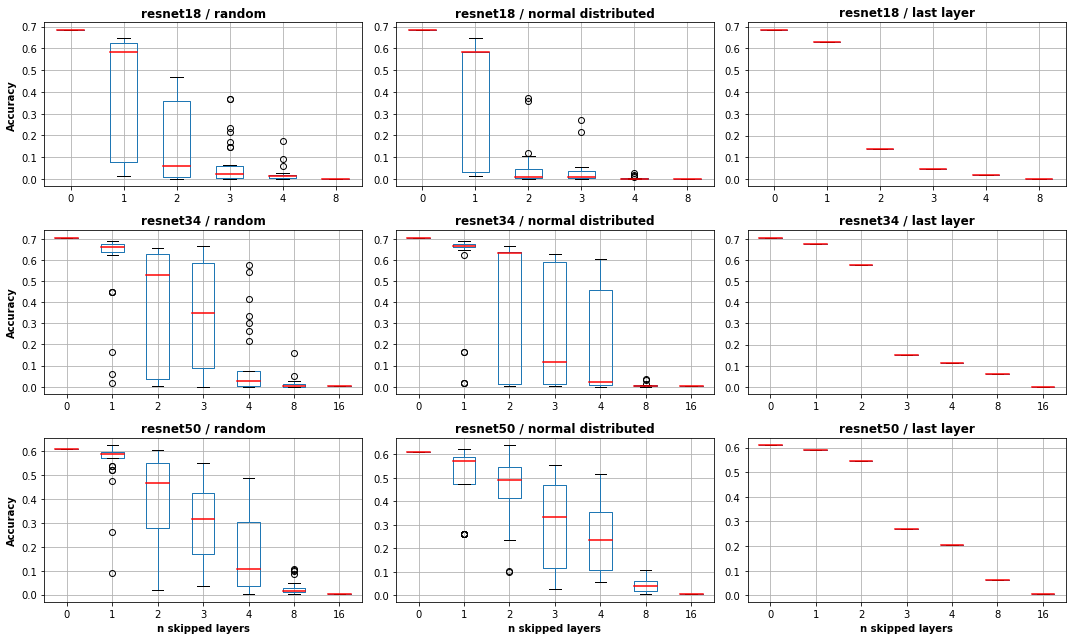

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))

r_archs = ['resnet18', 'resnet34', 'resnet50']
r_pols = ['drop-rand-n', 'drop-norm-n', 'drop-last-rand-n']

for i, arch in enumerate(r_archs):
    for j, pol in enumerate(r_pols):
        printBoxPlotForArchAndPol(q_df, arch, pol, axes[i, j], i, j, last_idx=len(r_archs) - 1)

fig.tight_layout()
plt.show()

In [26]:
temp_df = s_df.query('arch == "resnet50" and pol == "drop-rand-n"')

temp_df

temp_df = temp_df.groupby(['skip_n', 'arch', 'pol']).agg({'time': 'mean'})

temp_df

,,,time
skip_n,arch,pol,
1,resnet50,drop-rand-n,0.799793
2,resnet50,drop-rand-n,0.742037
3,resnet50,drop-rand-n,0.687575
4,resnet50,drop-rand-n,0.655965
8,resnet50,drop-rand-n,0.412202
16,resnet50,drop-rand-n,0.076524


In [7]:
from scipy import stats
#print(s_df)
#s_df[['run', 'skip_n', 'arch', 'time']]

grouped_df = s_df.groupby(['skip_n', 'arch', 'pol']).agg({'time': [np.average]}).reset_index()
grouped_df

def getDataFrameWithoutOutliers(df):
    total_df = pd.DataFrame()
    
    for n in df['skip_n'].unique():
        for arch in df['arch'].unique():
            for pol in df['pol'].unique():
                if pol is not 'none':
                    temp_df = df[df['skip_n'] == n]
                    temp_df = temp_df[temp_df['arch'] == arch]
                    temp_df = temp_df[temp_df['pol'] == pol]
                
                    temp_df = temp_df[np.abs(temp_df.time-temp_df.time.mean()) <= (3 * temp_df.time.std())]
                    total_df = total_df.append(temp_df)
    return total_df

test2_df = getDataFrameWithoutOutliers(s_df).reset_index()
print(len(test2_df))
print(len(s_df))
grouped2_df = test2_df.groupby(['skip_n', 'arch', 'pol']).agg({'time': [np.average]}).reset_index()
grouped2_df = grouped2_df.append(grouped_df[grouped_df['pol'] == 'none']).reset_index()

print(len(grouped_df))

print(len(grouped2_df))

#grouped_df = grouped2_df
grouped_df = s_df.groupby(['skip_n', 'arch', 'pol']).agg({'time': 'mean'}).reset_index()
#grouped_df[grouped_df['arch'] == 'resnet50']

grouped_df = grouped_df.drop(grouped_df[(grouped_df.pol == 'none') & (grouped_df.skip_n > 1)].index)
#grouped_df[grouped_df['pol'] == 'none'].skip_n = 0
grouped_df.loc[(grouped_df.pol == 'none'), 'skip_n'] = 0


grouped_df[grouped_df['pol'] == 'none']

4669
4713
160
182


,skip_n,arch,pol,time
0,0,densenet121,none,0.085398
1,0,densenet169,none,0.137058
2,0,resnet101,none,2.187679
3,0,resnet152,none,2.381245
19,0,resnet18,none,0.185659
23,0,resnet34,none,0.326067
27,0,resnet50,none,0.833904


0, drop-rand-n, ['resnet18', 'resnet34', 'resnet50']
6
7
7
1, drop-norm-n, ['resnet18', 'resnet34', 'resnet50']
6
7
7
2, drop-last-rand-n, ['resnet18', 'resnet34', 'resnet50']
6
7
7


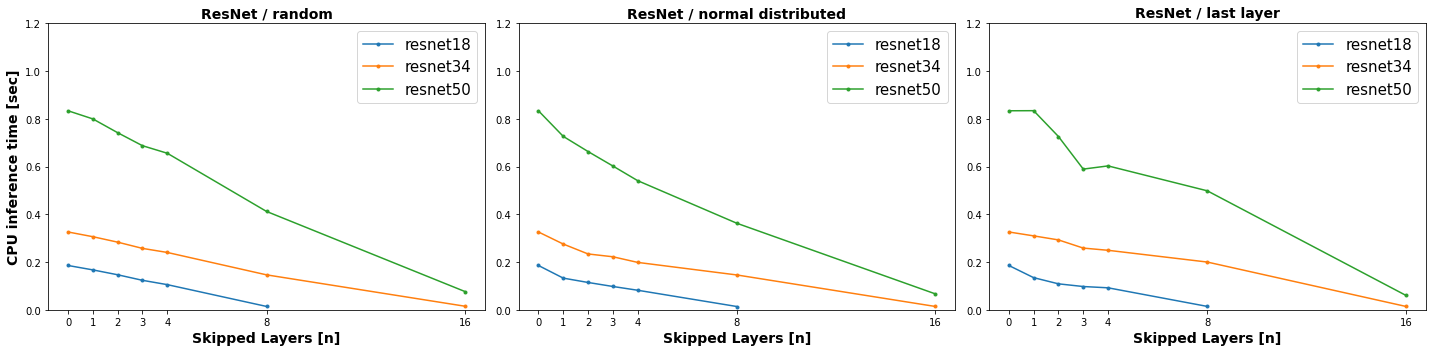

In [21]:



font = dict()
font['fontsize'] = 14
font['fontweight'] = 'bold'
def linePlotArchs(df, policy, archs, ax, max_y=None):
    if max_y is not None:
        ax.set_ylim([0.0, max_y])

    pol_df = df[df['pol'] == policy]

    arch_type = 'ResNet' if 'res' in archs[0] else 'DenseNet'

    ax.set_title(f'{arch_type} / {pol_trans[policy]}', font)
    for arch in archs:
        plot_df = pol_df[pol_df['arch'] == f'{arch}']
        plot_df = df[df['arch'] == arch][df['pol'] == "none"].append(plot_df)
        print(len(plot_df))
        ax.plot(plot_df.skip_n, plot_df.time,'.-', label=arch, axes=ax)
    ax.legend(fontsize=15)
    ax.set_xticks(plot_df['skip_n'])
    ax.set_xlabel('Skipped Layers [n]', font)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes[0].set_ylabel('CPU inference time [sec]', font)


for i, pol in enumerate(r_pols):
    print(f'{i}, {pol}, {r_archs}')
    linePlotArchs(grouped_df, pol, r_archs, axes[i], 1.2)

fig.tight_layout()
plt.show()

In [22]:
grouped_df[grouped_df['pol'] == 'none']

,skip_n,arch,pol,time
0,0.0,densenet121,none,0.085398
1,0.0,densenet169,none,0.137058
2,0.0,resnet101,none,2.187679
3,0.0,resnet152,none,2.381245
19,0.0,resnet18,none,0.185659
23,0.0,resnet34,none,0.326067
27,0.0,resnet50,none,0.833904


8
8
8
8
8
8
8
8


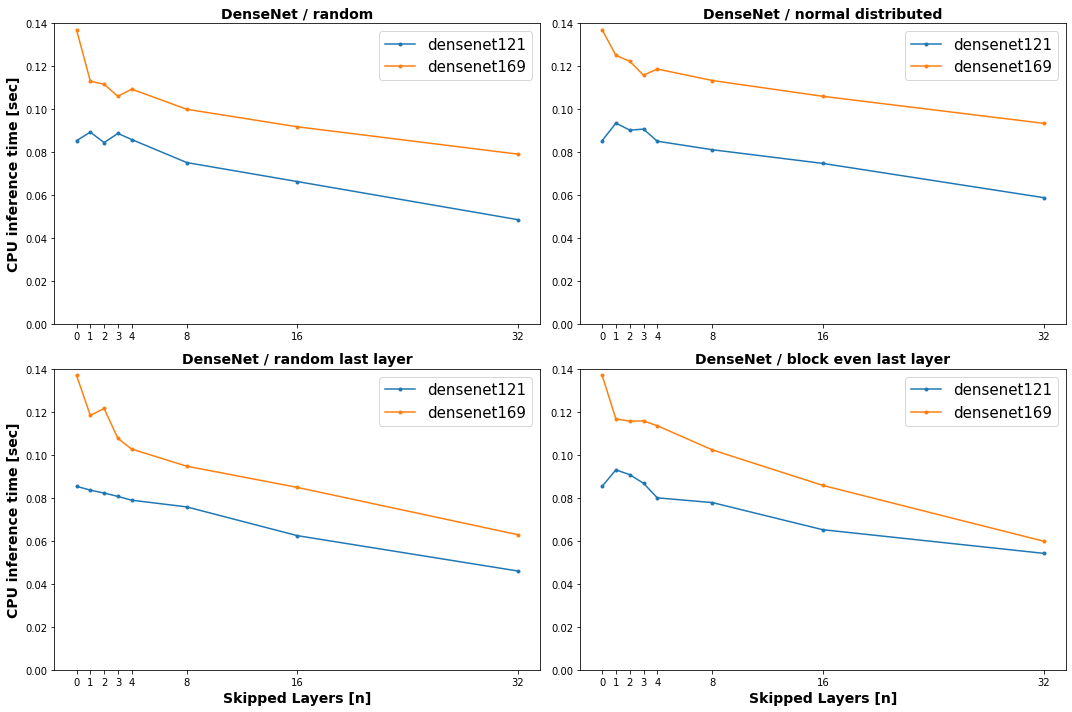

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes[0, 0].set_ylabel('CPU inference time [sec]', font)
axes[1, 0].set_ylabel('CPU inference time [sec]', font)
axes_ls = [axes[0, 0], axes[0, 1], axes[1,0], axes[1,1]]

for i, pol in enumerate(dense_pols):
    linePlotArchs(grouped_df, pol, d_archs, axes_ls[i], 0.14)

axes_ls[0].set_xlabel('')
axes_ls[1].set_xlabel('')

fig.tight_layout()
plt.show()

In [76]:
def executeQualityBench(arch_name, loader):
    prec = random.random()
    acc = random.random()
    rec = random.random()

    return prec, acc, rec

def executeSpeedBench(arch_name, loader):
    speed = random.random()
    return speed



d = {'run': [], 'skip_n': [], 'bench_type': [], 'arch': [], 'pol': [], 'prec': [], 'rec': [], 'acc': [], 'time': []}


loader = []

for bench_type in bench_types:
    for arch, pol in arch_pol_tupl_ls:
        for skip_n in skip_layers_values:
            for run in range(runs):
                prec = 0.0
                rec = 0.0
                acc = 0.0
                time = 0.0
                if bench_type == 'quality':
                    prec, acc, rec = executeQualityBench(f'{arch}-{pol}', loader)
                    #print(f'{run} - {skip_n} - {bench_type} - {arch} - {pol} - {prec:.6f} - {rec:.6f} - {acc:.6f}')
                elif bench_type == 'speed':
                    time = executeSpeedBench(f'{arch}-{pol}', loader)
                    #print(f'{run} - {skip_n} - {bench_type} - {arch} - {pol} - {time:.6f}')
                else:
                    raise ValueError('Benchmark type not supported')
                
                d['run'].append(run)
                d['skip_n'].append(skip_n)
                d['bench_type'].append(bench_type)
                d['arch'].append(arch)
                d['pol'].append(pol)
                d['prec'].append(prec)
                d['rec'].append(rec)
                d['acc'].append(acc)
                d['time'].append(time)

In [81]:
df = pd.DataFrame(data=d)
reports_path = os.path.join(os.getcwd())
print(reports_path)
if not os.path.isdir:
    os.mkdir(reports_path)
df.to_csv(os.path.join(reports_path, 'run.csv'), index=False)
columns = list(d.keys())
print(columns)

/home/alex/Projects/Studium/anytimeDnn/reports
['run', 'skip_n', 'bench_type', 'arch', 'pol', 'prec', 'rec', 'acc', 'time']


Plot for pol1
Plot for pol2


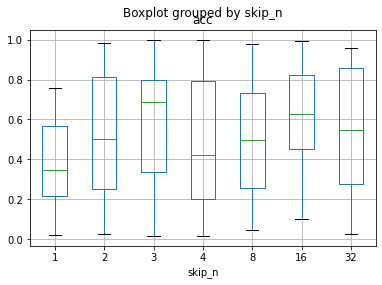

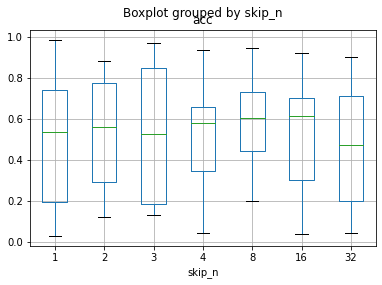

In [11]:
msd_archs = ['msdnet4', 'msdnet5']
msd_pol = ['none']

reports_list = os.listdir()

reports_list = list(filter(lambda x: 'msdnet' in x, sorted(reports_list)))

reports_list

q_df = list(filter(lambda x: 'quality' in x, reports_list))
s_df = list(filter(lambda x: 'speed' in x, reports_list))

printList(q_df)
printList(s_df)

q_df = getDataFrameFromReports(q_df)
s_df = getDataFrameFromReports(s_df)

print(len(q_df))
print(q_df)
print(len(s_df))
print(s_df)


quality-msdnet4-run.csv
quality-msdnet5-run.csv

speed-msdnet4-none-run.csv
speed-msdnet5-none-run.csv
9
   classifier     arch       acc      prec       rec        f1
0           1  msdnet4  0.553911  0.553295  0.590119  0.540677
1           2  msdnet4  0.583510  0.582652  0.600541  0.575144
2           3  msdnet4  0.610994  0.611061  0.634818  0.606631
3           4  msdnet4  0.608879  0.608220  0.635328  0.608440
4           1  msdnet5  0.572939  0.572803  0.575581  0.566445
5           2  msdnet5  0.606765  0.606667  0.622708  0.605060
6           3  msdnet5  0.674419  0.674962  0.694823  0.673240
7           4  msdnet5  0.642706  0.643068  0.659354  0.641907
8           5  msdnet5  0.655391  0.656364  0.672531  0.656260
270
     classifier     arch        time
0             1  msdnet4   34.512026
1             1  msdnet4   33.905089
2             1  msdnet4   33.341044
3             1  msdnet4   33.577891
4             1  msdnet4   34.048861
..          ...      ...         ...
2

In [46]:
grouped_sdf = s_df.groupby(['classifier', 'arch'], as_index=False).agg({'time': 'mean'})


print(grouped_sdf[grouped_sdf['arch'] == 'msdnet5'])

   classifier     arch        time
1           1  msdnet5   31.248975
3           2  msdnet5   57.899610
5           3  msdnet5   78.043686
7           4  msdnet5   94.528414
8           5  msdnet5  101.213596


'\n\ndef linePlotArchs(df, policy, archs, ax, max_y=None):\n    if max_y is not None:\n        ax.set_ylim([0.0, max_y])\n\n    pol_df = df[df[\'pol\'] == policy]\n\n    arch_type = \'ResNet\' if \'res\' in archs[0] else \'DenseNet\'\n\n    ax.set_title(f\'{arch_type} / {pol_trans[policy]}\', font)\n    for arch in archs:\n        plot_df = pol_df[pol_df[\'arch\'] == f\'{arch}\']\n        plot_df = df[df[\'arch\'] == arch][df[\'pol\'] == "none"].append(plot_df)\n        print(len(plot_df))\n        ax.plot(plot_df.skip_n, plot_df.time,\'.-\', label=arch, axes=ax)\n    ax.legend(fontsize=15)\n    ax.set_xticks(plot_df[\'skip_n\'])\n    ax.set_xlabel(\'Skipped Layers [n]\', font)\n\nfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))\naxes[0].set_ylabel(\'CPU inference time [sec]\', font)\n'

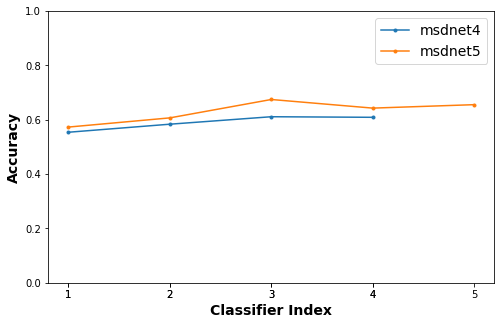

In [42]:

font = dict()
font['fontsize'] = 14
font['fontweight'] = 'bold'
grouped_qdf = q_df.groupby(['classifier', 'arch'], as_index=False).agg({'acc': 'mean', 'prec': 'mean', 'rec': 'mean', 'f1': 'mean'})
grouped_qdf = grouped_qdf[['classifier', 'arch', 'acc']]

fix, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
axes.set_ylabel('Accuracy', font)
axes.set_ylim([0.0, 1.0])
axes.set_xticks(grouped_qdf['classifier'])
axes.set_xlabel('Classifier Index', font)

plot_df = grouped_qdf[grouped_qdf['arch'] == 'msdnet4']
axes.plot(plot_df.classifier, plot_df.acc, '.-', label='msdnet4')
plot_df = grouped_qdf[grouped_qdf['arch'] == 'msdnet5']
axes.plot(plot_df.classifier, plot_df.acc, '.-', label='msdnet5')


axes.legend(fontsize=font['fontsize'])

"""

def linePlotArchs(df, policy, archs, ax, max_y=None):
    if max_y is not None:
        ax.set_ylim([0.0, max_y])

    pol_df = df[df['pol'] == policy]

    arch_type = 'ResNet' if 'res' in archs[0] else 'DenseNet'

    ax.set_title(f'{arch_type} / {pol_trans[policy]}', font)
    for arch in archs:
        plot_df = pol_df[pol_df['arch'] == f'{arch}']
        plot_df = df[df['arch'] == arch][df['pol'] == "none"].append(plot_df)
        print(len(plot_df))
        ax.plot(plot_df.skip_n, plot_df.time,'.-', label=arch, axes=ax)
    ax.legend(fontsize=15)
    ax.set_xticks(plot_df['skip_n'])
    ax.set_xlabel('Skipped Layers [n]', font)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes[0].set_ylabel('CPU inference time [sec]', font)
"""